# Heart Analysis

In this notebook we are showing an exemplar of SynthVAE in good practise.

SynthVAE is suitable for example datasets in which there are no time series variables. The heart dataset we use in heart.csv is given through a kaggle challenge found here <https://www.kaggle.com/datasets/fedesoriano/heart-failure-prediction> and is a combination of multiple open source datasets.

In order to run this notebook we need access to:

- training SynthVAE
- heart data folder (with synthetic data ran using the Heart_Pre_Processing.ipynb)
- adapted RDT module for reproducible results

We create a 10-fold split validation method. We then compare results between synthetic data created by SynthVAE & the original dataset. We will be comparing distributional metrics as well as downstream ML performance.

We opt to use decision trees as they are white box and openly interpretable - this will allow us to fully observe if trends captured in the original dataset are also captured within the synthetic dataset.

In [1]:
# Import necessary libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


from sklearn.model_selection import RepeatedStratifiedKFold, StratifiedKFold
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.metrics import accuracy_score
from sklearn.inspection import permutation_importance
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder
import sklearn.preprocessing
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import export_graphviz

import sys

import os
from os import listdir

sys.path.append("../")

import torch

# For VAE dataset formatting
from torch.utils.data import TensorDataset, DataLoader

# Opacus support for differential privacy
from opacus.utils.uniform_sampler import UniformWithReplacementSampler

from VAE import VAE, Encoder, Decoder

from utils import set_seed

from metrics import distribution_metrics, privacy_metrics

In [2]:
set_seed(0)

In [3]:
# Specify column configs

categorical_columns = [
    "Sex",
    "ChestPainType",
    "FastingBS",
    "RestingECG",
    "ExerciseAngina",
    "ST_Slope",
    "HeartDisease",
]

continuous_columns = [
    "Age", 
    "RestingBP", 
    "Cholesterol", 
    "MaxHR", 
    "Oldpeak",
]

Gather original dataset

In [ ]:
heart_file = "Heart_Data/Original_Data/heart.csv"

pd.read_csv(heart_file)

# Loop over datasets

In [4]:
data_dir_no_dp = "Heart_Data/Synthetic_Data/No_DP/" # directory for all your synthetic data - without differential privacy
data_dir_dp = "Heart_Data/Synthetic_Data/DP/" # Directory for all your synthetic data - with differential privacy

files = heart_file + listdir(data_dir_no_dp) # + listdir(data_dir_dp)

for i, file in enumerate(files):
    
    # Create folder/directory for results of this dataset
    
    os.mkdir("results_{}.csv".format(file[:-4]))
    
    dataset = pd.read_csv(file) # Read in dataset as pandas dataframe
    
    X,y = dataset.loc[:, ["Age", "Sex", "ChestPainType", "RestingBP", "Cholesterol", "FastingBS", "RestingECG", "MaxHR", "ExerciseAngina", "Oldpeak", "ST_Slope"]], dataset.loc[:, "HeartDisease"]
    
    # define the model & pipeline
    numeric_transformer = StandardScaler()

    categorical_transformer = OneHotEncoder()

    preprocessor_variables = ColumnTransformer(
        transformers=[
            ("num", numeric_transformer, continuous_columns),
            ("cat", categorical_transformer, categorical_columns[:-1]),
        ]
    )

    # configure the cross-validation procedure
    cv_outer = RepeatedStratifiedKFold(n_splits=10, n_repeats=5, random_state=1)

    outer_test_results = []
    outer_train_results = []
    outer_configs = []

    for train_ix, test_ix in cv_outer.split(X, y):
    
        # split data
        X_train, X_test = X.iloc[train_ix], X.iloc[test_ix]
        y_train, y_test = y.iloc[train_ix], y.iloc[test_ix]
    
        # configure the cross-validation procedure
        cv_inner = StratifiedKFold(n_splits=3, shuffle=True, random_state=1)
    
        # define the model
        pipe = Pipeline([('scaler', preprocessor_variables), ('model', DecisionTreeClassifier(random_state=0))])
    
        # define search space
        param_grid = dict(model__max_depth=[1,2,3], model__criterion=['gini', 'entropy'], model__splitter=['best', 'random'])
    
        # define search
        search = GridSearchCV(pipe, param_grid, scoring='accuracy', cv=cv_inner, refit=True, verbose=0)
    
        # execute search
        result = search.fit(X_train, y_train)
    
        # get the best performing model fit on the whole training set
        best_model = result.best_estimator_
    
        # evaluate model on the hold out dataset
        yhat = best_model.predict(X_test)
    
        # evaluate the model
        acc = accuracy_score(y_test, yhat)
    
        # store the all relevant results
        outer_test_results.append(acc)
        outer_train_results.append(result.best_score_)
        outer_configs.append(result.best_params_)
    
        # report progress
        print('>acc=%.3f, est=%.3f, cfg=%s' % (acc, result.best_score_, result.best_params_))
    # summarize the estimated performance of the model
    print('Accuracy: %.3f (%.3f)' % (np.mean(outer_results), np.std(outer_results)))
    
    if(i!=0): # If we are using the synthetic sets - lets calculate distributional & privacy metrics
        
        user_metrics = [
            "SVCDetection",
            "GMLogLikelihood",
            "CSTest",
            "KSTest",
            "KSTestExtended",
            "ContinuousKLDivergence",
            "DiscreteKLDivergence",
        ]
        
        distributional_metrics = distribution_metrics(
            gower_bool=False,
            distributional_metrics=user_metrics,
            data_supp=heart_file,
            synthetic_supp=dataset,
            categorical_columns=categorical_columns,
            continuous_columns=continuous_columns,
            saving_filepath=None,
            pre_proc_method="GMM",
        )
        
        privacy_metric = privacy_metrics(
            private_variable="Sex",
            data_supp=heart_file,
            synthetic_supp=dataset,
            categorical_columns=categorical_columns,
            continuous_columns=continuous_columns,
            saving_filepath=None,
            pre_proc_method="GMM",
        )

# Gathering Original Fidelity Results

Now we run our detection tree model on the original heart dataset to get an initial breakdown of results:

- We are running a 10 fold stratified validation method that is repeated three times using shuffling for each fold
- We are using sklearn decision trees
- We pre-process after the splitting has been done
- We set the <b>random_state</b> for reproducible data splits each time & we are using stratified to ensure roughly equivalent distributions of heart event to non-heart event in each fold

In [3]:
X,y = heart_data.loc[:, ["Age", "Sex", "ChestPainType", "RestingBP", "Cholesterol", "FastingBS", "RestingECG", "MaxHR", "ExerciseAngina", "Oldpeak", "ST_Slope"]], heart_data.loc[:, "HeartDisease"]

In [39]:
# define the model & pipeline
numeric_transformer = StandardScaler()

categorical_transformer = OrdinalEncoder()

preprocessor_variables = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, continuous_columns),
        ("cat", categorical_transformer, categorical_columns[:-1]),
    ]
)

# configure the cross-validation procedure
cv_outer = RepeatedStratifiedKFold(n_splits=10, n_repeats=5, random_state=1)

outer_test_results = []
outer_train_results = []
outer_configs = []

for train_ix, test_ix in cv_outer.split(X, y):
    
    # split data
    X_train, X_test = X.iloc[train_ix], X.iloc[test_ix]
    y_train, y_test = y.iloc[train_ix], y.iloc[test_ix]
    
    # configure the cross-validation procedure
    cv_inner = StratifiedKFold(n_splits=3, shuffle=True, random_state=1)
    
    # define the model
    pipe = Pipeline([('scaler', preprocessor_variables), ('model', DecisionTreeClassifier(random_state=0))])
    
    # define search space
    param_grid = dict(model__max_depth=[1,2,3], model__criterion=['gini', 'entropy'], model__splitter=['best', 'random'])
    
    # define search
    search = GridSearchCV(pipe, param_grid, scoring='accuracy', cv=cv_inner, refit=True, verbose=0)
    
    # execute search
    result = search.fit(X_train, y_train)
    
    # get the best performing model fit on the whole training set
    best_model = result.best_estimator_
    
    # evaluate model on the hold out dataset
    yhat = best_model.predict(X_test)
    
    # evaluate the model
    acc = accuracy_score(y_test, yhat)
    
    # store the all relevant results
    outer_test_results.append(acc)
    outer_train_results.append(result.best_score_)
    outer_configs.append(result.best_params_)
    
    # report progress
    print('>acc=%.3f, est=%.3f, cfg=%s' % (acc, result.best_score_, result.best_params_))
# summarize the estimated performance of the model
print('Accuracy: %.3f (%.3f)' % (np.mean(outer_results), np.std(outer_results)))

>acc=0.848, est=0.834, cfg={'model__criterion': 'gini', 'model__max_depth': 3, 'model__splitter': 'best'}
>acc=0.707, est=0.844, cfg={'model__criterion': 'gini', 'model__max_depth': 3, 'model__splitter': 'best'}
>acc=0.859, est=0.826, cfg={'model__criterion': 'gini', 'model__max_depth': 3, 'model__splitter': 'random'}
>acc=0.837, est=0.840, cfg={'model__criterion': 'entropy', 'model__max_depth': 3, 'model__splitter': 'best'}
>acc=0.772, est=0.845, cfg={'model__criterion': 'gini', 'model__max_depth': 3, 'model__splitter': 'random'}
>acc=0.880, est=0.823, cfg={'model__criterion': 'gini', 'model__max_depth': 3, 'model__splitter': 'best'}
>acc=0.793, est=0.840, cfg={'model__criterion': 'gini', 'model__max_depth': 3, 'model__splitter': 'best'}
>acc=0.837, est=0.832, cfg={'model__criterion': 'gini', 'model__max_depth': 3, 'model__splitter': 'random'}
>acc=0.824, est=0.823, cfg={'model__criterion': 'gini', 'model__max_depth': 3, 'model__splitter': 'best'}
>acc=0.857, est=0.836, cfg={'model__c

## Model Creation

Here we start creation of our scikit tree model. We decide to use tree based models as they offer greatly improved interpretability. This will allow us to look at feature importance breakdowns at classification stage and make comparisons between synthetic & original data.

In [42]:
# define the model using the best hyperparameters
clf = Pipeline([('scaler', preprocessor_variables), ('model', DecisionTreeClassifier(random_state=0, max_depth=3, splitter='best'))])
clf = clf.fit(X, y)

## Variable Feature Importance

Now lets look at the decision graphs to identify interpretable cutoff points in our data

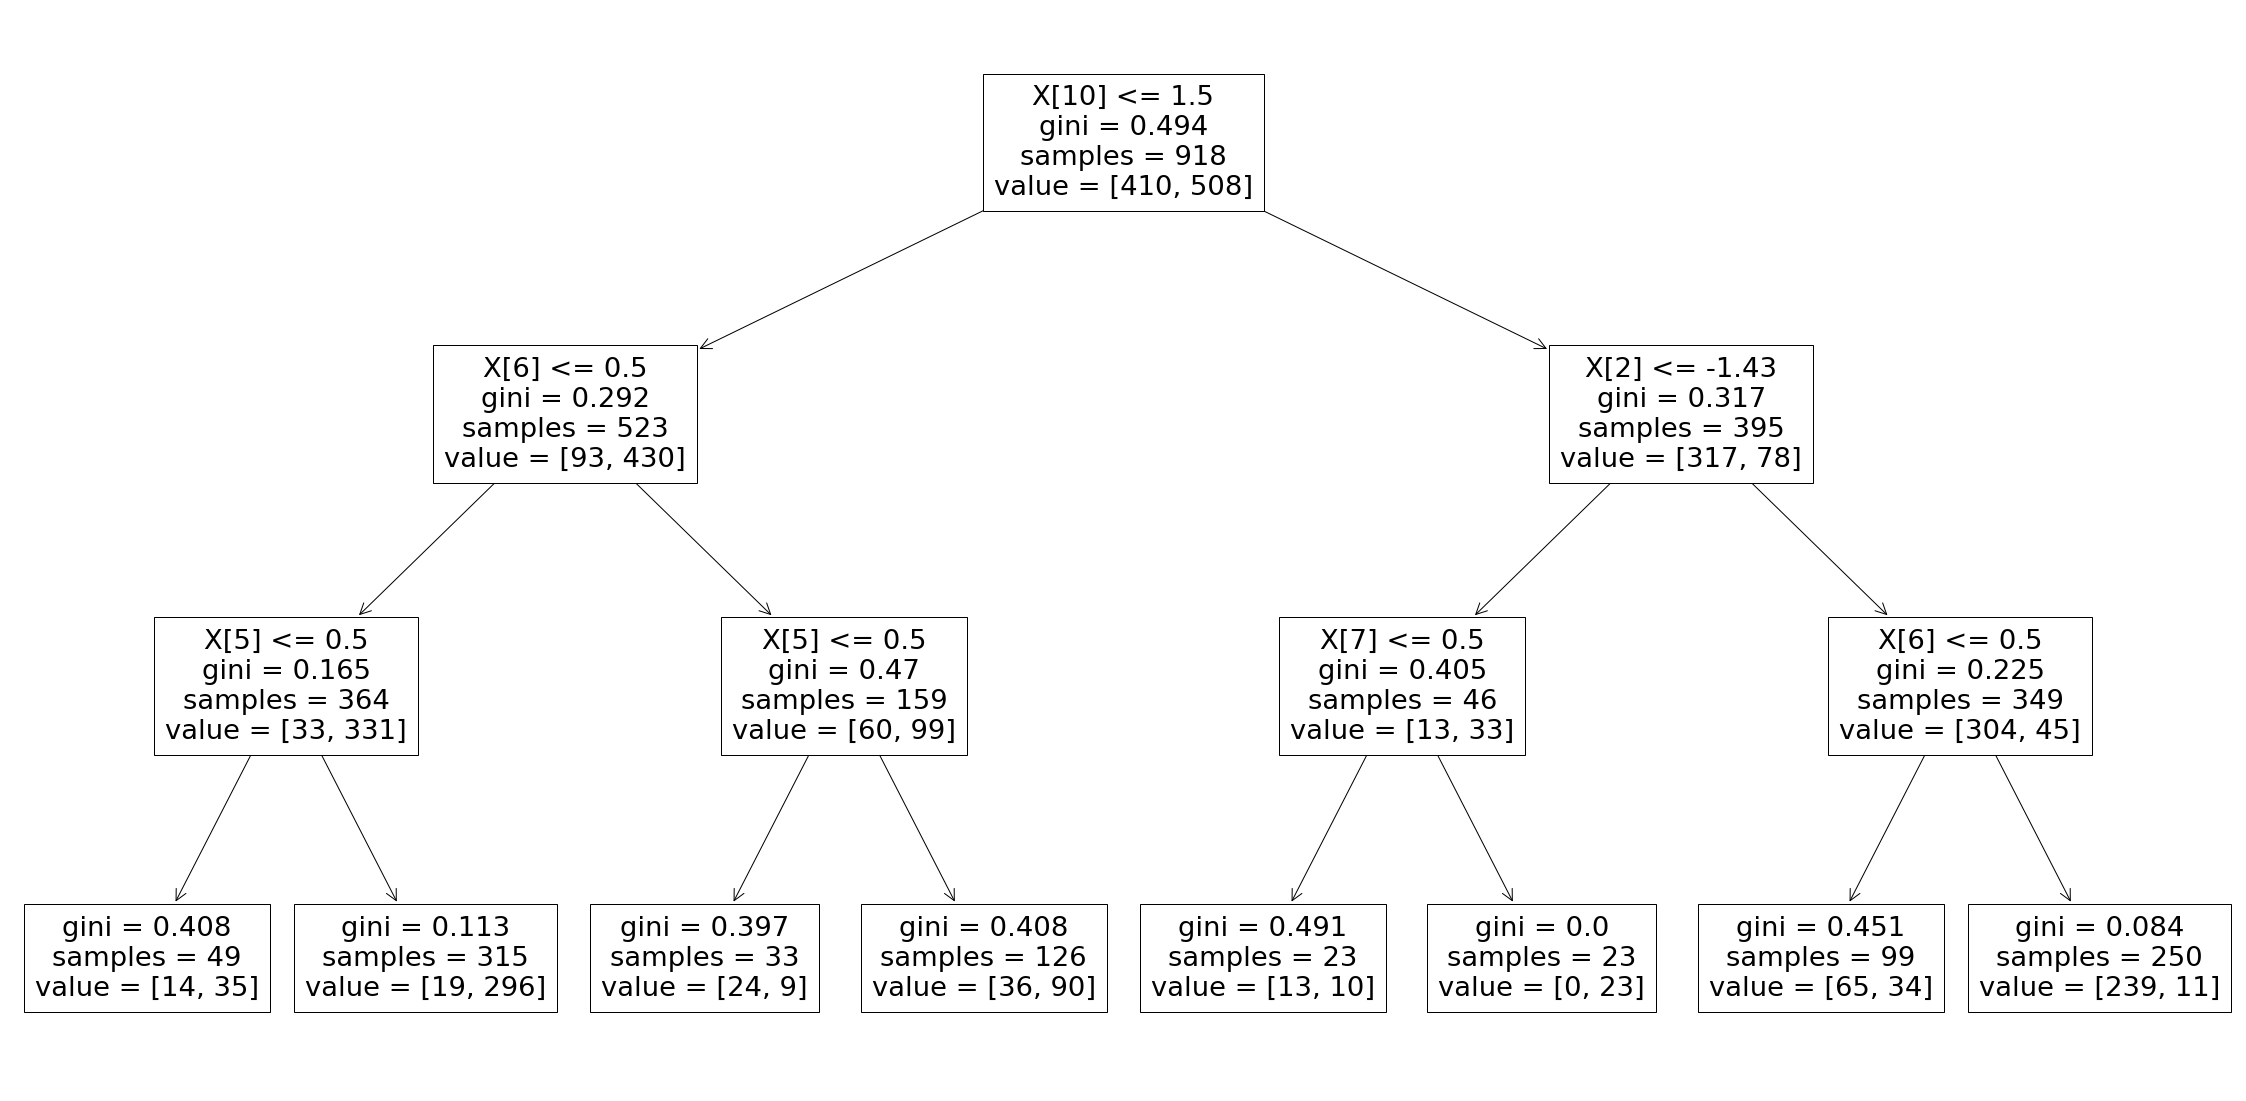

In [57]:
plt.figure(figsize=(40,20))
tree.plot_tree(clf['model'])
plt.savefig("tree_diagram_{}.png".format(dataset))
plt.show()

In [48]:
feature_importances = clf['model'].feature_importances_

array([0.        , 0.        , 0.10971108, 0.        , 0.        ,
       0.05654082, 0.12047496, 0.02863993, 0.        , 0.        ,
       0.6846332 ])

In [50]:
result = permutation_importance(
    clf, X, y, n_repeats=10, random_state=42
)

In [51]:
permutation_importances = result.importances_mean

array([0.        , 0.0248366 , 0.01851852, 0.        , 0.02668845,
       0.01851852, 0.        , 0.        , 0.        , 0.        ,
       0.24324619])

# Distributional Metrics

For synthetic sets we want to also save any distributional/statistical metrics of interest between the synthetic/real datasers

# Privacy Metrics

For synthetic sets we also want to observe how privacy differences influence the workflow & data fidelity